# 12_Grunerlokka_PuLP_v1.2

Minimize response time for police car units to events in Grünerløkka district, Oslo. The problem is formulated as a linear programming problem and solved using the PuLP library.  

Area: Grünerløkka district (small network)  
Obj. func: Minimize total response time  
Event points: Sample from original network nodes (fast for testing purposes)  
Event weight: None  
Possible car locations: Sampled 60 nodes -> Filtered to 34 -> 4 in solution  
Car service distance: 800m  
Car max capacity: 300 events  
Implementation: OSMnx, NetworkX, Pandana, PuLP, Descartes  
Computation time: Node centrality (4s), PuLP add constraints (1min 16sec) + solve (1min 14sec)  

In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-03-09T20:17:40.836804+01:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import nearest_points
from descartes import PolygonPatch
from pyproj import Transformer
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import pulp

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

osmnx     : 1.9.1
pandana   : 0.7
networkx  : 3.2.1
shapely   : 2.0.3
matplotlib: 3.8.3
pandas    : 2.2.1
geopandas : 0.14.3
pulp      : 2.8.0
numpy     : 1.26.4



## 1. Load the data
### 1.1 Loading a small road network of Grünerløkka for testing.
For all input data we change the CRS from WGS84 to UTM33N. This is done to make the distance calculations easier.  
Also trying to use pygeos instead of shapely for faster geometry operations. However, pygeos is not entirely integrated with geopandas yet, so we need to convert geometries back to shapely geometries for inserting them into geopandas dataframes.

In [3]:
### Road network file of Grünerløkka, Oslo

# 1) Read from local path
gruner_filepath = "../data/GrunerServiceImputed.graphml" # GraphML format (with speed and travel time)
gruner_graph = ox.load_graphml(gruner_filepath) # originally in WGS84 (EPSG:4326)

# 2) Fetch from OSM - using OSMnx 
# gruner_graph = ox.graph_from_place('Grünerløkka, Oslo, Norway', network_type="drive_service") # originally in WGS84 (EPSG:4326)

In [4]:
gruner_graph = ox.projection.project_graph(gruner_graph, to_crs='EPSG:32633') # project to UTM zone 33N
print(f"Type of gruner_graph: {type(gruner_graph)}")
print(f"CRS of gruner_graph:  {gruner_graph.graph['crs']}")

# plot graph
# fig, ax = ox.plot_graph(gruner_graph, node_size=4, edge_linewidth=0.5, edge_color="w")

Type of gruner_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of gruner_graph:  EPSG:32633


Convert graph to GeoDataFrame and plot it.   
`osmnx.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)` - Convert a MultiDiGraph to node and/or edge GeoDataFrames.

In [5]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(gruner_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
# nodes.head()
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


,,,osmid,lanes,name,highway,oneway,reversed,length,geometry,speed_kph,travel_time,maxspeed,ref,junction,width,service,bridge,tunnel,access
u,v,key,,,,,,,,,,,,,,,,,,
79448,3165357950,0,129061337,2,Maridalsveien,secondary,False,False,107.935,"LINESTRING (262538.332 6650300.213, 262536.391...",44.500,8.700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3165357950,79448,0,129061337,2,Maridalsveien,secondary,False,True,107.935,"LINESTRING (262538.592 6650406.186, 262532.197...",44.500,8.700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next we compute closeness centrality and add it as an attribute to the nodes GeoDataFrame.  
TODO: Find faster way to compute closeness centrality.

In [6]:
%%time
# compute node closeness centrality
node_centrality = nx.closeness_centrality(gruner_graph, wf_improved=True, distance="travel_time")

# add node closeness centrality to the nodes GeoDataFrame
nodes['closeness_centrality'] = pd.Series(node_centrality)
nodes.head(2)

CPU times: total: 3.36 s
Wall time: 4 s


,y,x,street_count,lon,lat,highway,ref,geometry,closeness_centrality
osmid,,,,,,,,,
79448,6650300.213,262538.332,3,10.751,59.922,NaN,NaN,POINT (262538.332 6650300.213),0.004
3165357950,6650406.186,262538.592,3,10.751,59.923,NaN,NaN,POINT (262538.592 6650406.186),0.004


Now, we have added the closeness centrality as an attribute to the nodes GeoDataFrame, we can use this to filter out better candidates for police car locations.

## 2. Sample event points

In [7]:
# random nodes from the graph
seed = 42
nr_of_car_nodes = 60
nodes_sample = nodes.sample(1010, random_state=seed) # sample 1010 random source nodes
car_nodes = nodes_sample.iloc[:nr_of_car_nodes]   # first X nodes are cars
event_nodes = nodes_sample.iloc[nr_of_car_nodes:] # rest of nodes are events
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}, nr of event nodes: {len(event_nodes)}")
nodes_sample.head(2)

Total nr of nodes: 1147, nr of police car nodes: 60, nr of event nodes: 950


,y,x,street_count,lon,lat,highway,ref,geometry,closeness_centrality
osmid,,,,,,,,,
1200788653,6650962.609,263720.996,1,10.771,59.928,NaN,NaN,POINT (263720.996 6650962.609),0.006
10026959862,6650672.488,263912.191,1,10.775,59.926,NaN,NaN,POINT (263912.191 6650672.488),0.007


## 3. Filter/Selection of police car candidate points
We have sampled random points from the road network. Next we filter the candidate points on the following critera to discard the most unsuitable points. This will reduce computational time and make the LP problem more manageable.

- Discard nodes with lowest closeness centrality (i.e. nodes that are not well connected to the rest of the network)
- Discard nodes that are too close to each other


Input nr of car nodes: 60
Remaining nr of car nodes: 48, after discarding the 12 (20%) remote car nodes with lowest closeness centrality



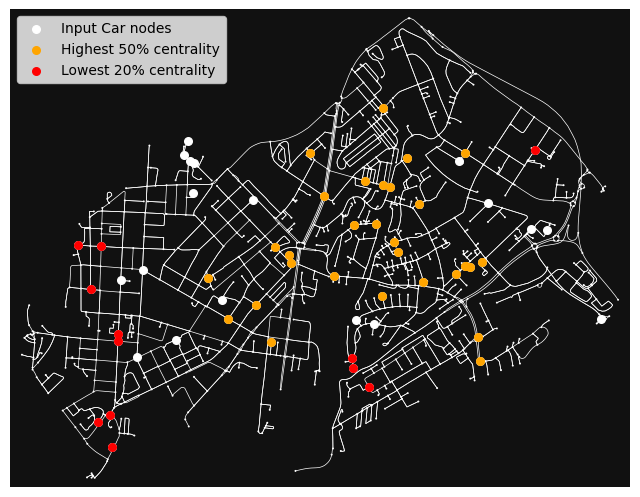

In [8]:
# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))

def filter_and_plot_nodes_by_centrality(geo_df, top_percent, bottom_percent, input_graph, plot=False):
    """
    Filters a GeoDataFrame to find the top X% and bottom Y% of nodes based on closeness_centrality,
    optionally plots these nodes, and returns a filtered GeoDataFrame excluding the bottom Y% nodes.
    
    :param geo_df: GeoDataFrame with a 'closeness_centrality' column and 'x', 'y' for plotting.
    :param top_percent: The top percentage of nodes to select based on closeness_centrality.
    :param bottom_percent: The bottom percentage of nodes to select based on closeness_centrality.
    :param plot: Whether to plot the nodes.
    :return: A filtered GeoDataFrame excluding the bottom Y% closeness_centrality nodes.
    """
    # Calculate the number of nodes for each selection
    num_top = int(len(geo_df) * top_percent)
    num_bottom = int(len(geo_df) * bottom_percent)
    
    # Sort the DataFrame by closeness_centrality
    sorted_geo_df = geo_df.sort_values(by='closeness_centrality', ascending=False)
    
    # Select the top X% and bottom Y%
    central_car_nodes = sorted_geo_df.head(num_top)
    remote_car_nodes = sorted_geo_df.tail(num_bottom)
    
    # print(f"Selection of {top_percent*100}% highest and {bottom_percent*100}% lowest closeness centrality car nodes\nTotal nr of nodes: {len(sorted_geo_df)}\nNr of remote car nodes: {len(remote_car_nodes)},\nNr of central car nodes: {len(central_car_nodes)}")
    

    print(f"Input nr of car nodes: {len(geo_df)}")
    print(f"Remaining nr of car nodes: {len(sorted_geo_df) - len(remote_car_nodes)}, after discarding the {len(remote_car_nodes)} ({bottom_percent*100:.0f}%) remote car nodes with lowest closeness centrality\n")
    if plot:
        # Plot all nodes
        fig, ax = ox.plot_graph(input_graph, node_color="white", node_size=2, edge_linewidth=0.5, edge_color="w", show=False, close=False)
        ax.scatter(geo_df['x'], geo_df['y'], c='white', s=30, label="Input Car nodes")
        ax.scatter(central_car_nodes['x'], central_car_nodes['y'], c='orange', s=30, label=f"Highest {top_percent*100:.0f}% centrality")
        ax.scatter(remote_car_nodes['x'], remote_car_nodes['y'], c='red', s=30, label=f"Lowest {bottom_percent*100:.0f}% centrality")
        ax.legend()
        plt.show()
    
    # Remove the bottom Y% nodes from the original GeoDataFrame
    filtered_geo_df = sorted_geo_df.drop(remote_car_nodes.index)
    return filtered_geo_df

car_nodes_gdf_central = filter_and_plot_nodes_by_centrality(geo_df=car_nodes_gdf, top_percent=0.5, bottom_percent=0.2, input_graph=gruner_graph, plot=True)

Input nr of car nodes: 48
Remaining nr of car nodes: 34, after removing the 14 nodes that are within 100 m of each other



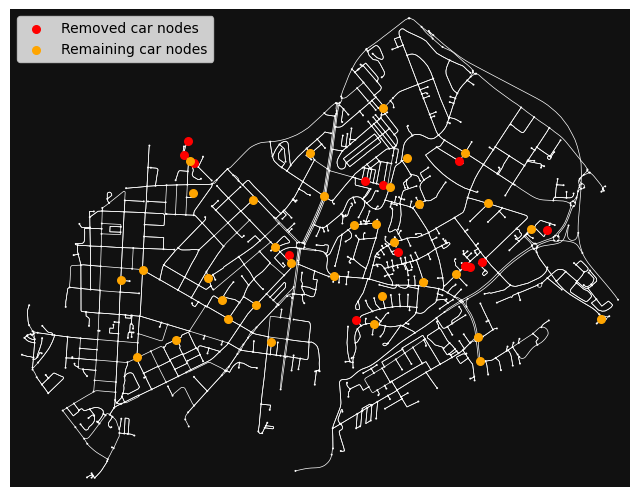

In [9]:
def filter_nodes_by_proximity(geo_df, min_distance, input_graph, criterion_col=None, prefer='higher', plot=False):
    """
    Removes nodes from a GeoDataFrame that are within a specified minimum distance of each other.
    
    :param geo_df: GeoDataFrame with a 'geometry' column.
    :param min_distance: Minimum distance in the GeoDataFrame's coordinate reference system units.
    :param input_graph: The graph from which the nodes were extracted, used for plotting.
    :param criterion_col: Column name to use as a criterion for removing nodes. Optional.
    :param prefer: Determines which node to keep based on the criterion_col ('higher' or 'lower').
    :param plot: Whether to plot the nodes.
    :return: A filtered GeoDataFrame excluding nodes within the minimum distance of each other.
    """
    sindex = geo_df.sindex # Create a spatial index for the GeoDataFrame
    to_remove = [] # List to keep track of indices to remove
    
    # Iterate over the GeoDataFrame
    for index, row in geo_df.iterrows():
        # Create a buffer around the geometry and find potential matches using the spatial index
        buffer = row.geometry.buffer(min_distance)
        possible_matches_index = list(sindex.intersection(buffer.bounds))
        possible_matches = geo_df.iloc[possible_matches_index]
        
        # Actual neighbors are those within the specified distance, excluding the row itself
        actual_neighbors = possible_matches[possible_matches.distance(row.geometry) < min_distance]
        actual_neighbors = actual_neighbors.drop(index, errors='ignore')
        
        for neighbor_index, neighbor in actual_neighbors.iterrows():
            if criterion_col:
                # Decide which node to remove based on the criterion
                if (prefer == 'higher' and neighbor[criterion_col] > row[criterion_col]) or \
                   (prefer == 'lower' and neighbor[criterion_col] < row[criterion_col]):
                    to_remove.append(index)
                    break  # Current node will be removed, no need to check other neighbors
                else:
                    to_remove.append(neighbor_index)
            else:
                # If no criterion is given, default to removing the neighbor
                to_remove.append(neighbor_index)
    
    # Remove duplicates and drop the nodes
    to_remove = list(set(to_remove))
    filtered_geo_df = geo_df.drop(index=to_remove)
    
    # Reset index to clean up the DataFrame
    filtered_geo_df.reset_index(drop=True, inplace=True)

    print(f"Input nr of car nodes: {len(geo_df)}")
    print(f"Remaining nr of car nodes: {len(geo_df) - len(to_remove)}, after removing the {len(to_remove)} nodes that are within {min_distance} m of each other\n")

    if plot:
        # Plot all nodes
        fig, ax = ox.plot_graph(input_graph, node_color="white", node_size=2, edge_linewidth=0.5, edge_color="w", show=False, close=False)
        ax.scatter(geo_df.loc[to_remove, 'x'], geo_df.loc[to_remove, 'y'], c='red', s=30, label="Removed car nodes")
        ax.scatter(filtered_geo_df['x'], filtered_geo_df['y'], c='orange', s=30, label=f"Remaining car nodes")
        ax.legend(); plt.show()
    return filtered_geo_df

car_nodes_gdf_filtered = filter_nodes_by_proximity(geo_df=car_nodes_gdf_central, min_distance=100, input_graph=gruner_graph, criterion_col='closeness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

Now we use the GeoDataFrames from `osmnx` to create a `pandana` network.

Pandana networks is defined like this:   
`pandana.network.Network(node_x, node_y, edge_from, edge_to, edge_weights, twoway=True)`  

 **edge_weights**: DataFrame, all numerics   
- Specifies one or more impedances on the network which define the distances between nodes.  
- Multiple impedances can be used to capture travel times at different times of day, for instance.

We will use both ``length`` and ``travel_time`` as edge weights. However, we must specify which one to use when querying the network (cannot calculate with both at the same time).

In [10]:
# reset index so our origins and destinations are not in index
edges = edges.reset_index()

# create network with pandana
gruner_pandana_network = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of gruner_pandana_network: {type(gruner_pandana_network)}")
print(f"Network nodes:")
gruner_pandana_network.nodes_df.head(3)

type of gruner_pandana_network: <class 'pandana.network.Network'>
Network nodes:


,x,y
osmid,,
79448,262538.332,6650300.213
3165357950,262538.592,6650406.186
79465,263161.645,6651034.904


In [11]:
print(f"Network edges: ")
gruner_pandana_network.edges_df.head(3)

Network edges: 


,from,to,length,travel_time
0,79448,3165357950,107.935,8.700
1,3165357950,79448,107.935,8.700
2,79465,106183,139.757,11.300


Next, it’s probably a good idea (though not strictly required) to precompute a given horizon distance so that aggregations don’t perform the network queries unnecessarily.   
This is done by calling the following code, where 3000 meters is used as the horizon distance:

In [12]:
gruner_pandana_network.precompute(3000)

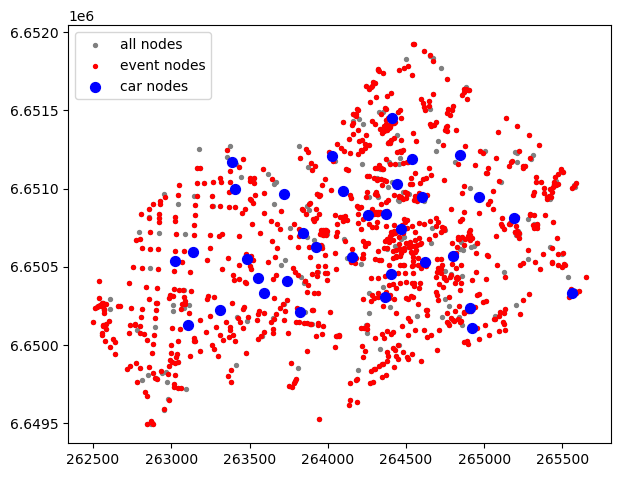

In [13]:
# Plot nodes for overview
fig, ax = plt.subplots(figsize=(7, 7))
nodes.plot(ax=ax, color='gray', markersize=8)
event_nodes.plot(ax=ax, color='r', markersize=8)
car_nodes_gdf_filtered.plot(ax=ax, color='b', markersize=50)
ax.legend(['all nodes', 'event nodes','car nodes'])
plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

First, identify the nearest node to each Police car and Event.
- [network.get_node_ids()](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids)

In [14]:
# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = gruner_pandana_network.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
event_nodes_pdna = gruner_pandana_network.get_node_ids(x_col=event_nodes.x, y_col=event_nodes.y).values
# car_nodes_pdna

In [15]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

# for o, d in zip(origins, destinations):
#     print(f"{o}, {d}")

In [16]:
%%time
# distance between each possible pair of facilities-clients combination
distances = gruner_pandana_network.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = gruner_pandana_network.shortest_path_lengths(origins, destinations, imp_name='travel_time')

print(type(distances))
print("Number of distances calculated: ", len(distances), "\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5], "\n")

<class 'list'>
Number of distances calculated:  32300 

5 first origin-destination distances [m]     : [1706.198, 849.246, 1768.017, 1162.255, 1771.035]
5 first origin-destination travel times [sec]: [126.7, 77.2, 163.0, 133.3, 163.7] 

CPU times: total: 656 ms
Wall time: 77.1 ms


In [17]:
# print the statistics for distances and travel times
print("Distances statistics:")
print(pd.Series(distances).describe())
print("\nTravel times statistics:")
print(pd.Series(travel_times).describe())

Distances statistics:
count   32300.000
mean     1469.552
std       717.164
min         0.963
25%       928.316
50%      1391.852
75%      1939.964
max      4126.651
dtype: float64

Travel times statistics:
count   32300.000
mean      138.543
std        62.991
min         0.100
25%        92.100
50%       133.800
75%       179.900
max       369.400
dtype: float64


In [18]:
# Restructure the distances and travel times arrays into a DataFrame (Cost Matrix) and add the car and event node ids as columns

# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['policeCarNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
# CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(car_nodes_gdf_filtered, left_on='policeCarNodeID', right_index=True)
CostMatrix_extended = CostMatrix.merge(event_nodes, left_on='eventNodeID', right_index=True, suffixes=('_car', '_event'))
# CostMatrix_extended.keys()
CostMatrix_extended.head(3)

,distance,travel_time,policeCarNodeID,eventNodeID,y,x,street_count,lon,lat,highway,ref,geometry,closeness_centrality
0,1706.198,126.700,7246056981,1762320635,6651119.752,265490.076,3,10.803,59.931,NaN,NaN,POINT (265490.076 6651119.752),0.004
1,849.246,77.200,7246056981,11398964086,6650680.670,264875.961,1,10.792,59.926,NaN,NaN,POINT (264875.961 6650680.670),0.007
2,1768.017,163.000,7246056981,80042,6651572.379,264887.919,1,10.791,59.934,NaN,NaN,POINT (264887.919 6651572.379),0.005


In [19]:
# Export to CSV with compression and excluding index
# CostMatrix.to_csv('../data/CostMatrix.csv', index=False, compression='gzip')
# CostMatrix.to_csv('../data/CostMatrix_gruner_samples.csv', index=False)

# Load cost matrix from CSV
# CostMatrix_imported = pd.read_csv('../data/CostMatrix_gruner_samples.csv')
# CostMatrix_imported.head()

Now, we have made Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Model the problem
We will use the Python library PuLP to model and solve the optimization problem.

The objective is to minimize the average response time to events, by optimally positioning a fixed number of police cars.

### Notation

Let's define the notation that will be used to formulate the problem:
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events, each associated with a node in $N$ and a severity score.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.

### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M_i \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$

This mathematical formulation provides a clear LP framework for optimizing the placement of police cars to minimize response times, ensuring each event is adequately covered. The next step, translating this formulation into Python code, involves using an LP solver like PulP to define and solve this optimization problem.


#### Setup LP problem

In [20]:
# Constants
K = 4  # Number of police car locations in final solution
M = 300   # Maximum number of events a single police car can respond to

# Sets
P = CostMatrix['policeCarNodeID'].unique()  # Potential police car locations
E = CostMatrix['eventNodeID'].unique()  # Events

# Preprocessing options for performance (becomes more relevant when scaling up to larger area)
# Pre-compute mappings or aggregations that can reduce the complexity or number of iterations required during constraint setup.
# E.g. only check events within a certain distance of each police car location.

# Create the LP object
# Minimization problem since we want to minimize the total travel time
problem = pulp.LpProblem("PoliceCarLocationOptimization", pulp.LpMinimize) # Minimization problem
problem

PoliceCarLocationOptimization:
MINIMIZE
None
VARIABLES

#### Add decision variables and objective function

In [21]:
%%time
# Decision Variables
# x[i] = 1 if a police car is placed at location i, 0 otherwise
x = pulp.LpVariable.dicts("x", P, cat='Binary')  # Police car placement
# y[i, j] = 1 if event j is assigned to police car i, 0 otherwise
y = pulp.LpVariable.dicts("y", [(i, j) for i in P for j in E], cat='Binary')  # Event assignment

# Objective Function
# Minimize the total response time
problem += pulp.lpSum([CostMatrix.set_index(['policeCarNodeID', 'eventNodeID']).loc[(i, j), 'travel_time'] * y[(i, j)] for i in P for j in E]), "TotalResponseTime"
# This is the same as:
# for i in P:
#     for j in E:
#         problem += CostMatrix.loc[(i, j), 'travel_time'] * y[(i, j)]
# problem

CPU times: total: 1min 3s
Wall time: 1min 16s


#### Add problem constraints

In [22]:
%%time
# Police Car Placement Constraint
problem += pulp.lpSum([x[i] for i in P]) == K, "NumberOfPoliceCars"
# This is the same as:
# for i in P:
#     problem += x[i] <= 1
# And means that we can only place a police car at one location

# Event Assignment Constraint
for j in E:
    problem += pulp.lpSum([y[(i, j)] for i in P]) == 1, f"EventAssignment_{j}"
# This is the same as:
# for j in E:
#     for i in P:
#         problem += y[(i, j)] <= 1
# And means that each event must be assigned to exactly one police car

# Validity Constraint
for i in P:
    for j in E:
        problem += y[(i, j)] <= x[i], f"Validity_{i}_{j}"
# This is the same as:
# for i in P:
#     for j in E:
#         problem += y[(i, j)] <= x[i]
# And means that we can only assign an event to a police car if it is placed at that location

# Capacity Constraint
for i in P:
    problem += pulp.lpSum([y[(i, j)] for j in E]) <= M * x[i], f"Capacity_{i}"
# This is the same as:
# for i in P:
#     problem += pulp.lpSum([y[(i, j)] for j in E]) <= M * x[i]
# And means that each police car can only respond to a maximum of M events

# problem

CPU times: total: 438 ms
Wall time: 659 ms


In [23]:
# from pulp import LpSolver_CMD
# class COIN_CMD(LpSolver_CMD):
#     """The COIN CLP/CBC LP solver
#     now only uses cbc
#     """

#     def defaultPath(self):
#         return self.executableExtension("test_path")

#     def __init__(self, path = None, keepFiles = 0, mip = 1,
#             msg = 0, cuts = None, presolve = None, dual = None,
#             strong = None, options = [],
#             fracGap = None, maxSeconds = None, threads = None):
        # a =2

#### Run the solver - using the default solver (CBC)

In [24]:
%%time
# TODO: check out setting optimality gap (fracGap=0.1) for faster approximate solutions 

# Solve the problem - using the default solver (CBC)
status = problem.solve(pulp.PULP_CBC_CMD()) # CBC is the default solver
status

CPU times: total: 625 ms
Wall time: 1min 14s


1

.solve() calls the underlying solver, modifies the model object, and returns the integer status of the solution, which will be 1 if the optimum is found.   
 For the rest of the status codes, see [LpStatus](https://www.coin-or.org/PuLP/constants.html#pulp.constants.LpStatus).

 
| LpStatus key         | string value  | numerical value |
|----------------------|---------------|-----------------|
| LpStatusOptimal      | "Optimal"     | 1               |
| LpStatusNotSolved    | "Not Solved"  | 0               |
| LpStatusInfeasible   | "Infeasible"  | -1              |
| LpStatusUnbounded    | "Unbounded"   | -2              |
| LpStatusUndefined    | "Undefined"   | -3              |

You can get the optimization results as the attributes of model. The function value() and the corresponding method .value() return the actual values of the attributes:

### 5.2 Inspect the results

In [25]:
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")

print(f"Goal: minimize the objective function (total response time)")
print(f"Objective function value: {pulp.value(problem.objective):.2f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")

# for var in problem.variables():
#     print(f"{var.name}: {var.value()}")

# Constraints
# for name, constraint in problem.constraints.items():
#     print(f"{name}: {constraint.value()}")

status: 1, Optimal
Goal: minimize the objective function (total response time)
Objective function value: 54989.20 seconds, or 916.49 minutes, or 15.27 hours


In [26]:
# Results Processing

# convert to array
optimal_police_locations = [i for i in P if x[i].varValue == 1]
assigned_events = {j: i for i in P for j in E if y[(i, j)].varValue == 1}

# optimal_police_locations = np.array(optimal_police_locations)
print(f"Optimal police car locations: {optimal_police_locations}, type: {type(optimal_police_locations)}")

# print(f"Assigned events: {assigned_events}, type: {type(assigned_events)}")

# group the events by police car
events_by_police_car = {} # structured as {police_car: [event1, event2, ...]}
for event, police_car in assigned_events.items():
    if police_car in events_by_police_car:
        events_by_police_car[police_car].append(event)
    else:
        events_by_police_car[police_car] = [event]

# print(f"Events by police car: {events_by_police_car}, type: {type(events_by_police_car)}")

Optimal police car locations: [3211547041, 1200648800, 786011978, 1387801966], type: <class 'list'>


In [27]:
# Next is creating GeoDataFrames for the police car locations and the assigned events with coordinates

# Get the coordinates of the optimal police car locations
optimal_police_car_locations_gdf = nodes[nodes.index.isin(optimal_police_locations)]
# optimal_police_car_locations_gdf

# export optimal_police_car_locations_gdf to CSV
optimal_police_car_locations_gdf.to_csv('../data/GrunerOptimalLocations.csv', index=False)

# Get the coordinates of the assigned events
assigned_events_gdf = nodes[nodes.index.isin(list(assigned_events.keys()))]
print(type(assigned_events_gdf))
assigned_events_gdf.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>


,y,x,street_count,lon,lat,highway,ref,geometry,closeness_centrality
osmid,,,,,,,,,
79448,6650300.213,262538.332,3,10.751,59.922,NaN,NaN,POINT (262538.332 6650300.213),0.004
3165357950,6650406.186,262538.592,3,10.751,59.923,NaN,NaN,POINT (262538.592 6650406.186),0.004


## 6. Visualization

### 6.1 Plot the possible police car locations and events

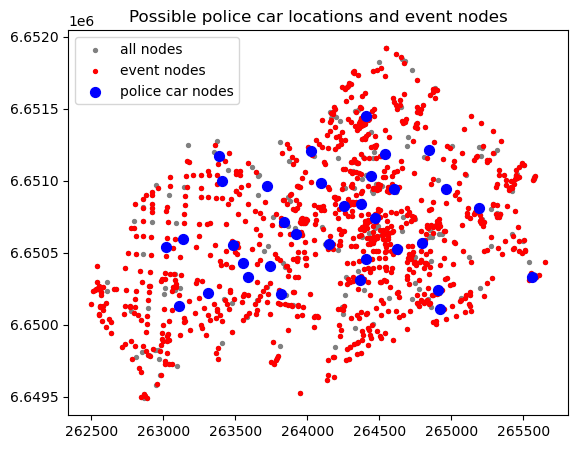

In [28]:
# Plot nodes for overview with title
fig, ax = plt.subplots(figsize=(7, 5))
nodes.plot(ax=ax, color='gray', markersize=8)
event_nodes.plot(ax=ax, color='r', markersize=8)
car_nodes_gdf_filtered.plot(ax=ax, color='b', markersize=50)
ax.legend(['all nodes', 'event nodes','police car nodes'])
plt.title(f"Possible police car locations and event nodes")
plt.show()

### 6.2 Plot the optimal police car locations and events

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 54989 sec | 916.5 min | 15.27 hours

Police car id:3211547041 handles 300 events | Capacity 100 % | Total response time: 19120 min | Avg response time: 1.9 min
Police car id:1200648800 handles 300 events | Capacity 100 % | Total response time: 23739 min | Avg response time: 2.3 min
Police car id:786011978 handles 122 events | Capacity 41 % | Total response time: 10467 min | Avg response time: 2.5 min
Police car id:1387801966 handles 228 events | Capacity 76 % | Total response time: 21256 min | Avg response time: 2.7 min


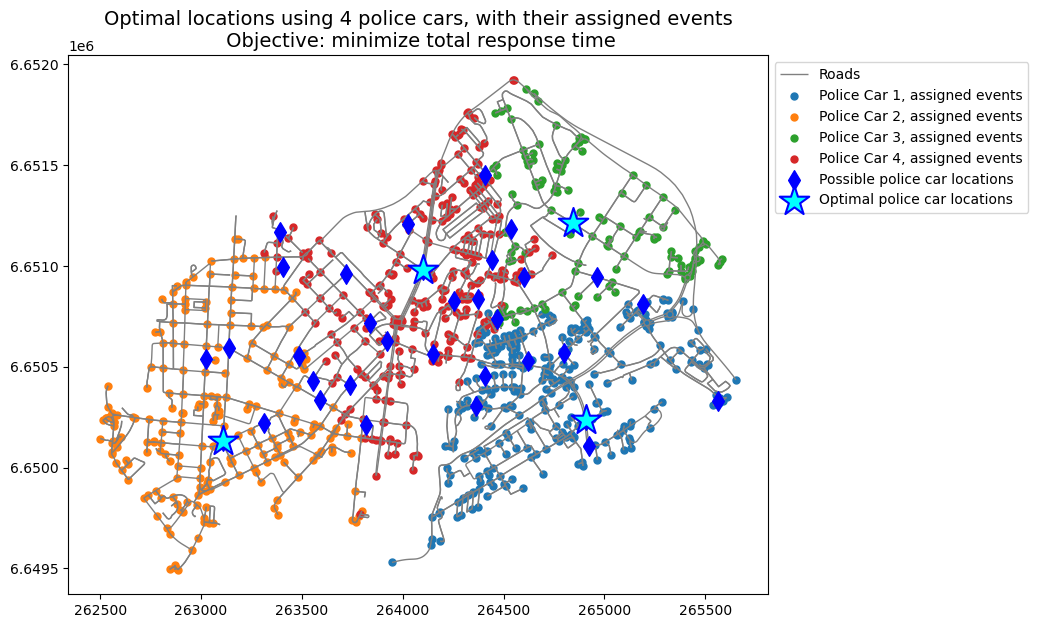

In [35]:
# Plot function
def plot_police_car_events(police_car_locations, events_by_police_car, nodes, edges, title):
    fig, ax = plt.subplots(figsize=(12, 7))
    edges.plot(ax=ax, linewidth=1, edgecolor='gray', label='Roads') # Road network
    for i, police_car in enumerate(police_car_locations.index):
        assigned_events_gdf[assigned_events_gdf.index.isin(events_by_police_car[police_car])].plot(ax=ax, color=f'C{i}', markersize=25, label=f'Police Car {i+1}, assigned events') # Events from police car i

    # plot all police car locations, but the optimal locations should
    # police_car_locations.plot(ax=ax, color='blue', marker='*', markersize=300, label='Optimal Police Car Locations') # Optimal police car locations

    # plot not chosen police car locations, and optimal/chosen locations, but the optimal locations should be more visible and stand out with a border
    car_nodes_gdf_filtered.plot(ax=ax, color='b', marker='d', markersize=100, label='Possible police car locations', zorder=3) # All police car locations
    police_car_locations[police_car_locations.index.isin(optimal_police_locations)].plot(ax=ax, color='cyan', marker='*', edgecolor='blue', linewidth=1.5, markersize=500, label='Optimal police car locations', zorder=3)
    ax.set_title(title, fontsize=14)
    plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1)); plt.show()

print("Solution from Linear Programming (LP) model:")
print(f"Goal: minimize objective function (total response time)")
print(f"Objective function value: {pulp.value(problem.objective):.0f} sec | {pulp.value(problem.objective)/60:.1f} min | {pulp.value(problem.objective)/3600:.2f} hours\n")
for police_car, events in events_by_police_car.items():
    # print(f"Police car id:{police_car} handles {len(events)} events, using {len(events)/M*100:.0f}% of its capacity. Total response time of {sum(CostMatrix_extended.loc[CostMatrix_extended['eventNodeID'].isin(events), 'travel_time'])/60:.0f} minutes. Average response time of {np.mean(CostMatrix_extended.loc[CostMatrix_extended['eventNodeID'].isin(events), 'travel_time'])/60:.1f} minutes")
    print(f"Police car id:{police_car} handles {len(events)} events | Capacity {len(events)/M*100:.0f} % | Total response time: {sum(CostMatrix_extended.loc[CostMatrix_extended['eventNodeID'].isin(events), 'travel_time'])/60:.0f} min | Avg response time: {np.mean(CostMatrix_extended.loc[CostMatrix_extended['eventNodeID'].isin(events), 'travel_time'])/60:.1f} min")

# plot results
plot_police_car_events(optimal_police_car_locations_gdf, events_by_police_car, nodes, edges, f"Optimal locations using {K} police cars, with their assigned events\n Objective: minimize total response time")

No weights (severity scores) are not used in this model.  
Still, the summed total response time for all police cars sum up to a larger value than the objective function for some reason.

TODO: double check the response time calculation for each police car. MultiIndexing of CostMatrix, etc.

## 6.3 Visualize isochrones


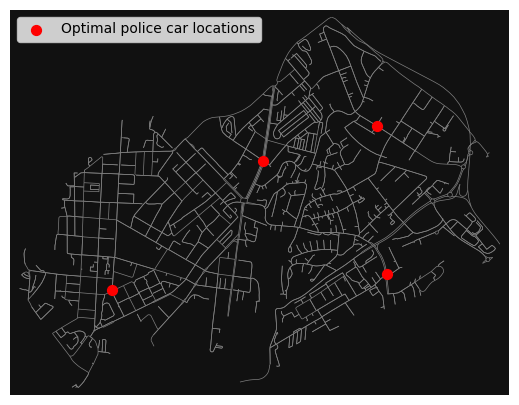

In [30]:
# Define how many trip times to visualize
trip_times = [0.3, 0.7, 1.2] # in minutes

optimal_police_locations_ints = list(map(int, optimal_police_locations))

# plot graph with the optimal police car locations
fig, ax = ox.plot_graph(gruner_graph, node_color='w', node_size=0, edge_linewidth=0.5, edge_color='gray', show=False, close=False, figsize=(7,5))
ax.scatter(optimal_police_car_locations_gdf['x'], optimal_police_car_locations_gdf['y'], c='r', s=50, label="Optimal police car locations")
ax.legend(loc="upper left"); plt.show()

### 6.3.1 Plots nodes you can reach within each time

How far can you drive in 5, 10, 15, 20, and 25 minutes from the origin nodes? We'll use NetworkX to induce a subgraph of gruner_graph within each distance, based on trip time and travel speed.

C:\Users\torha\AppData\Local\Temp\ipykernel_26076\2982969653.py:2: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)# color the nodes according to isochrone then plot the street network


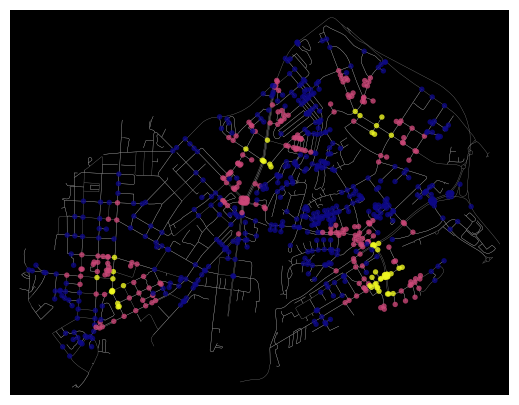

In [31]:
# # get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)# color the nodes according to isochrone then plot the street network

optimal_locations = optimal_police_locations_ints

# Initialize node_colors with 'none' for all nodes
node_colors = {node: 'none' for node in gruner_graph.nodes()}

for center_node in optimal_locations:
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(gruner_graph, center_node, radius=trip_time*60, distance='travel_time')
        for node in subgraph.nodes():
            # Only update the color if it is 'none' or if the new color is closer (i.e., a "stronger" isochrone)
            if node_colors[node] == 'none' or iso_colors.index(node_colors[node]) < iso_colors.index(color):
                node_colors[node] = color

# Prepare node colors and sizes for plotting
nc = [node_colors[node] for node in gruner_graph.nodes()]
ns = [15 if node_colors[node] != 'none' else 0 for node in gruner_graph.nodes()]

# Plotting the graph with the updated colors and sizes AND legend
fig, ax = ox.plot_graph(gruner_graph, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='k', edge_linewidth=0.2, edge_color='#999999', figsize=(7, 5), show=False, close=False)

### 6.3.2 Plot the time-distances as isochrones

How far can you drive in 5, 10, 15, 20, and 25 minutes from the origin nodes? We'll use a convex hull, which isn't perfectly accurate. A concave hull would be better, but shapely doesn't offer that.

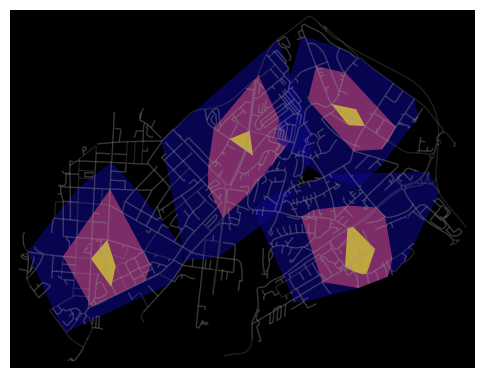

In [32]:
# Initialize a list to store isochrone polygons for all trip times and all center nodes
all_isochrone_polys = []

for center_node in optimal_locations:
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(gruner_graph, center_node, radius=trip_time*60, distance='travel_time')
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
        isochrone_polys.append(bounding_poly)
    all_isochrone_polys.append(isochrone_polys)

# Plot the network
fig, ax = ox.plot_graph(gruner_graph, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k', figsize=(6, 5))

# Plot each set of isochrone polygons with the corresponding colors
for isochrone_polys in all_isochrone_polys:
    for polygon, fc in zip(isochrone_polys, iso_colors):
        patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
plt.show()

### 6.3.3 Plot isochrones as buffers to get more faithful isochrones than convex hulls can offer

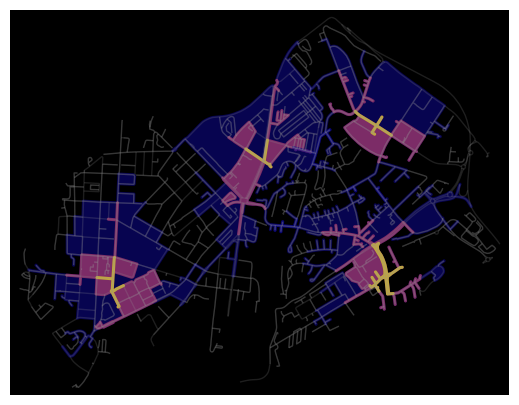

In [33]:
def make_iso_polys(G, center_nodes, edge_buff=25, node_buff=50, infill=False):
    all_isochrone_polys = []
    for center_node in center_nodes:
        isochrone_polys = []
        for trip_time in sorted(trip_times, reverse=True):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time*60, distance='travel_time')

            node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
            nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
            nodes_gdf = nodes_gdf.set_index('id')

            edge_lines = []
            for n_fr, n_to in subgraph.edges():
                f = nodes_gdf.loc[n_fr].geometry
                t = nodes_gdf.loc[n_to].geometry
                edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry', LineString([f, t]))
                edge_lines.append(edge_lookup)

            n = nodes_gdf.buffer(node_buff).geometry
            e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
            all_gs = list(n) + list(e)
            new_iso = gpd.GeoSeries(all_gs).unary_union
            
            if infill:
                new_iso = Polygon(new_iso.exterior)
            isochrone_polys.append(new_iso)
        all_isochrone_polys.append(isochrone_polys)
    return all_isochrone_polys

# Adjust edge_buff and node_buff as needed
isochrone_polys = make_iso_polys(gruner_graph, optimal_locations, edge_buff=10, node_buff=0, infill=True)

fig, ax = ox.plot_graph(gruner_graph, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k', figsize=(7, 5))

for isochrone_set in isochrone_polys:
    for polygon, fc in zip(isochrone_set, iso_colors):
        patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
plt.show()

### 6.3.4 Plot isochrones on interactive map

In [38]:
# Flatten the isochrone_polys list and create a matching trip_time list
flat_isochrone_polys = [poly for sublist in isochrone_polys for poly in sublist]
# Repeat each trip time for as many center nodes you have
repeated_trip_times = sorted(trip_times * len(optimal_locations), reverse=True)

crs_proj = ox.graph_to_gdfs(gruner_graph, nodes=False).crs  # Adjusted to explicitly state nodes=False
data = {'trip_time': repeated_trip_times, 'geometry': flat_isochrone_polys}
isochrones = gpd.GeoDataFrame(data, crs=crs_proj)

# Interactive leaflet map based on GeoDataFrame
# isochrones.explore(column='trip_time', cmap='Reds', tiles="OpenStreetMap", style_kwds={'fillOpacity': 0.5, 'lineOpacity': 0.5}) # light version
isochrones.explore(column='trip_time',cmap='Reds', tiles="CartoDB dark_matter") # dark version

TODO: fix minor bugs with isochrone zones on interactive map.